In [54]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from importlib import reload
import loss
import data_generator
import model
import train
import visualize
reload(loss)
reload(visualize)
reload(model)
reload(data_generator)
reload(train)

from data_generator import make_dataloaders
from model import MainModel
from train import train_model, load_model, build_backbone_unet, pretrain_generator
from background_detection import load_processed_images

In [55]:
COLOR_SPACE = 'Lab' # Lab or HSL or YCbCr
BACKBONE = 'resnet34' #backbones: resnet18, resnet34, vgg16_bn
path = "./data/part1"
l1loss = "SmoothL1Loss" # SmoothL1Loss or L1Loss
model_path =   f"./models/model_pretrained_noBG_part1_{BACKBONE}_{COLOR_SPACE}_{l1loss}.pt"
paths = load_processed_images('./background_scores/filtered_part1')
pretrained_model = f"{BACKBONE}-unet_noBG_{COLOR_SPACE}.pt"
np.random.seed(123)
paths_subset = np.random.choice(paths, 7500, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(7500)
train_idxs = rand_idxs[:6000] # choosing the first 800 as training set
val_idxs = rand_idxs[6000:] # choosing last 200 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

60 60


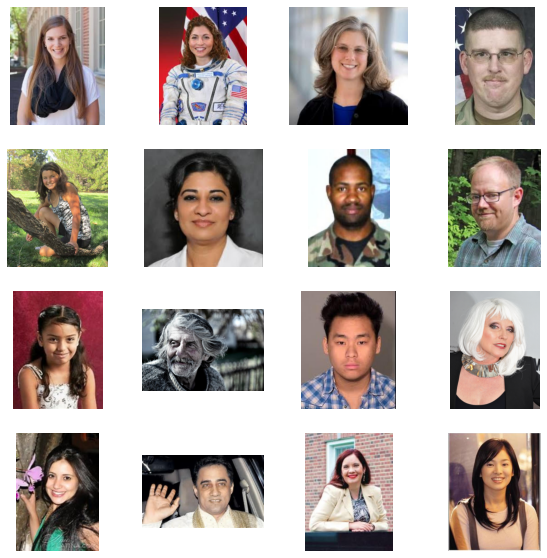

In [56]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [57]:
train_dl = make_dataloaders(paths=train_paths, split='train', color_space=COLOR_SPACE)
val_dl = make_dataloaders(paths=val_paths, split='val', color_space=COLOR_SPACE)

data = next(iter(train_dl))
known_channels, unknown_channels_ = data['known_channel'], data['unknown_channels']
print(known_channels.shape, unknown_channels_.shape)
print(len(train_dl), len(val_dl))

torch.Size([5, 1, 256, 256]) torch.Size([5, 2, 256, 256])
12 12


In [1]:
net_G = build_backbone_unet(n_input=1, n_output=2, size=256, backbone_name=BACKBONE)
opt = torch.optim.Adam(net_G.parameters(), lr=1e-4)
criterion = torch.nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 20, device=device)


SyntaxError: invalid syntax (<ipython-input-1-93b1b7d436e7>, line 5)

In [19]:
torch.save(net_G.state_dict(), pretrained_model)

In [61]:
net_G = build_backbone_unet(n_input=1, n_output=2, size=256, backbone_name=BACKBONE)
net_G.load_state_dict(torch.load(pretrained_model, map_location=device))

<All keys matched successfully>

In [64]:
loaded_model = MainModel(net_G=net_G, L1LossType=l1loss)
# _, loss_meter_dict = load_model(model_path, loaded_model) # for model loaded from file

model initialized with norm initialization
2



Epoch 3/152
Iteration 10/12


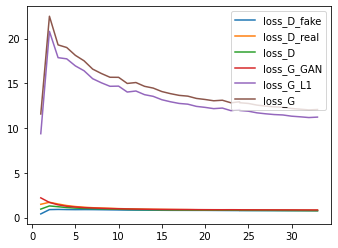

KeyboardInterrupt: 

In [65]:
#  train_model(loaded_model, train_dl, val_dl, COLOR_SPACE, 150, 10, loss_meter_dict=loss_meter_dict, save_path=model_path) # for model loaded from file
train_model(loaded_model, train_dl, val_dl, COLOR_SPACE, 1, 10, save_path=model_path) # for model trained from the begining 


In [ ]:
from visualize import visualize

loaded_model = MainModel(net_G=net_G)
_, loss_meter_dict = load_model(model_path, loaded_model)
for i, data in enumerate(iter(val_dl)):
    visualize(loaded_model, data, COLOR_SPACE, save=False)
    if i == 4:
        break